<a href="https://colab.research.google.com/github/Seouyang/Today-I-Learned/blob/master/vanilla_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network (GAN)

In [1]:
!nvidia-smi

Thu Feb  4 06:12:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [4]:
if not os.path.exists('./checkpoint'):
  os.mkdir('./checkpoint')
if not os.path.exists('./dataset'):
  os.mkdir('./dataset')
if not os.path.exists('./img'):
  os.mkdir('./img')
if not os.path.exists('./img/real'):
  os.mkdir('./img/real')
if not os.path.exists('./img/fake'):
  os.mkdir('./img/fake')

In [5]:
def vis_image(image):
  plt.imshow(image[0].detach().cpu().numpy(), cmap='gray') #visualize the first image from the torch tensor
  plt.show()

In [6]:
def save_gif(training_progress_images, images):
  img_grid = make_grid(images.data)
  img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
  img_grid = 255. * img_grid
  img_grid = img_grid.astype(np.uint8)
  training_progress_images.append(img_grid)
  imageio.mimsave('./img/training_progress.gif', training_progress_images)
  return training_progress_images

In [17]:
def vis_gif(training_progress_images):
    fig = plt.figure()
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    html = ani.to_html5_video()
    HTML(html)

In [8]:
def plot_gif(training_progress_images, plot_length=10):
  plt.close()
  fig = plt.figure()
  total_len = len(training_progress_images)
  for i in range(plot_length):
    im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
    plt.show()

In [9]:
def save_image_list(dataset, real):
  if real:
    base_path = './img/real'
  else:
    base_path = './img/fake'
  
  dataset_path = []

  for i in range(len(dataset)):
    save_path = f'{base_path}/image_{i}.png'
    dataset_path.append(save_path)
    vutils.save_image(dataset[i], save_path)
    
  return base_path

In [10]:
dataset = dset.MNIST(root='./dataset', download=True, transform=transforms.Compose([transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [11]:
#Generator
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(100, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid()
    )
  
  def forward(self, input):
    output = self.main(input)
    output = output.view(-1, 1, 28, 28)
    return output

In [12]:
#Discriminator
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Linear(784, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 256),
        nn.LeakyReLU(0.2),
        nn.Linear(256, 1), #binary classification
        nn.Sigmoid()
    )
  
  def forward(self, input):
    input = input.view(-1, 28*28)
    output = self.main(input)
    output = output.squeeze(dim=1)
    return output

In [13]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

In [14]:
noise = torch.randn(128, 100).cuda()

Update D network: Maximize $log(D(x))+log(1-D(G(z)))$

Update G network: Maximize $log(D(G(z)))$

In [15]:
fixed_noise = torch.randn(128, 100).cuda()
criterion = nn.BCELoss()

n_epoch = 200
training_progress_images_list = []
for epoch in range(n_epoch):
  for i, (data, _) in enumerate(dataloader):
    #update D
    #train with real
    netD.zero_grad()
    data = data.cuda()
    batch_size = data.size(0)
    label = torch.ones((batch_size,)).cuda()
    output = netD(data)
    errD_real = criterion(output, label)
    D_x = output.mean().item()

    #train with fake
    noise = torch.randn(batch_size, 100).cuda()
    fake = netG(noise)
    label = torch.zeros((batch_size,)).cuda()
    output = netD(fake.detach()) #detach fake image from gradient computation to prevent gradient flows to generator and make only discriminator updated
    errD_fake = criterion(output, label)
    D_G_z1 = output.mean().item()

    #loss backward
    errD = errD_real + errD_fake
    errD.backward()
    optimizerD.step()

    #update G
    #train with fake
    netG.zero_grad()
    label = torch.ones((batch_size,)).cuda()
    output = netD(fake)
    errG = criterion(output, label)
    D_G_z2 = output.mean().item()

    #loss backward
    errG.backward()
    optimizerG.step()
  
  print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

  fake = netG(fixed_noise)
  training_progress_images_list = save_gif(training_progress_images_list, fake)

  torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
  torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

[0/200] Loss_D: 0.0453 Loss_G: 5.9038 D(x): 0.9711 D(G(z)): 0.0104 / 0.0029
[1/200] Loss_D: 0.0113 Loss_G: 6.6197 D(x): 0.9930 D(G(z)): 0.0019 / 0.0013
[2/200] Loss_D: 0.0104 Loss_G: 7.3087 D(x): 0.9920 D(G(z)): 0.0011 / 0.0007
[3/200] Loss_D: 0.0038 Loss_G: 7.0205 D(x): 0.9997 D(G(z)): 0.0034 / 0.0009
[4/200] Loss_D: 0.0186 Loss_G: 7.2951 D(x): 0.9915 D(G(z)): 0.0028 / 0.0012
[5/200] Loss_D: 0.0060 Loss_G: 7.2349 D(x): 0.9999 D(G(z)): 0.0059 / 0.0011
[6/200] Loss_D: 0.0020 Loss_G: 7.5121 D(x): 0.9996 D(G(z)): 0.0016 / 0.0008
[7/200] Loss_D: 0.0031 Loss_G: 7.9306 D(x): 0.9998 D(G(z)): 0.0029 / 0.0008
[8/200] Loss_D: 0.0111 Loss_G: 7.6981 D(x): 0.9957 D(G(z)): 0.0061 / 0.0031
[9/200] Loss_D: 0.0110 Loss_G: 7.1013 D(x): 0.9999 D(G(z)): 0.0108 / 0.0015
[10/200] Loss_D: 0.0022 Loss_G: 10.6771 D(x): 0.9993 D(G(z)): 0.0015 / 0.0003
[11/200] Loss_D: 0.0046 Loss_G: 7.9935 D(x): 1.0000 D(G(z)): 0.0045 / 0.0008
[12/200] Loss_D: 0.0003 Loss_G: 11.0169 D(x): 0.9999 D(G(z)): 0.0002 / 0.0001
[13/200

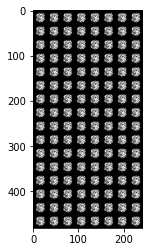

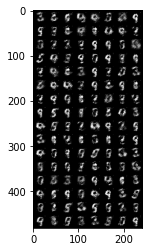

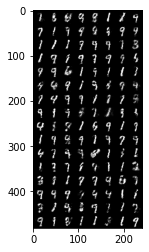

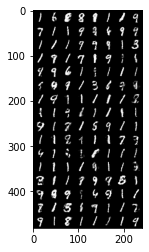

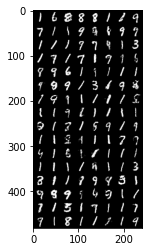

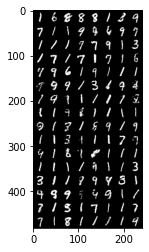

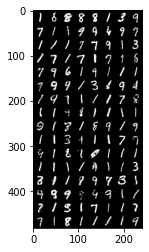

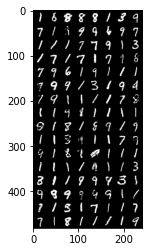

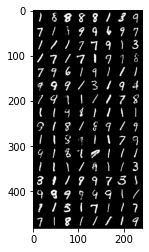

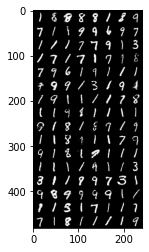

In [20]:
#visualize generated samples
vis_gif(training_progress_images_list)
plot_gif(training_progress_images_list)

**Evaluation using FID score**

FID score measures the distance between real dataset and fake dataset in feature space of Inception pretrained network. From the extracted features of real and fake dataset, we can compute mean and covariance of each features to calculate the distance between distributions.

In [21]:
#load FID score function from github
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg' -O inception.py
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1AtTxnuasIaSTTmI9MI7k8ugY8KJ1cw3Y' -O fid_score.py

--2021-02-04 08:12:22--  https://docs.google.com/uc?export=download&id=1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg
Resolving docs.google.com (docs.google.com)... 74.125.142.102, 74.125.142.138, 74.125.142.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uprktt7l6olpvbp2n8r89dk5k6qaqmdo/1612426275000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download [following]
--2021-02-04 08:12:22--  https://doc-0k-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uprktt7l6olpvbp2n8r89dk5k6qaqmdo/1612426275000/05323530314538631540/*/1InzR1qylS3Air4IvpS9CoamqJ0r9bqQg?e=download
Resolving doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-6s-docs.googleusercontent.com (doc-0k-6s-d

In [22]:
from fid_score import calculate_fid_given_paths

In [23]:
test_dataset = dset.MNIST(root='./dataset', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=50, shuffle=True, num_workers=2)

for i, (data, _) in enumerate(dataloader):
  real_dataset = data
  break

noise = torch.randn(50, 100).cuda()
fake_dataset = netG(noise)

In [24]:
real_image_path_list = save_image_list(real_dataset, True)
fake_image_path_list = save_image_list(fake_dataset, False)

In [25]:
fid_value = calculate_fid_given_paths([real_image_path_list, fake_image_path_list], 50, True, 2048)
print(f'FID score: {fid_value}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


FID score: 126.27289586481359
